<a href="https://colab.research.google.com/github/joaramirezra/Mineral-Border-Dectetion/blob/Johan/proyecto_geoimagenes.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Border Detection notebook


---


This notebook aims to help geologist or anyone who need to create an algorithm for detecting edges in a mineral or element that's contained into a thin section, also this will help to mask different kind of elements that need to be classified

---

# Libraries



In [268]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import pandas as pd
import cv2
import requests
import io
import PIL
from matplotlib import pyplot as plt

# Functions

#### *print_images ( @images)*
- **description**: This function let print many images using matplotlib library

- @images : images separated by commas 




In [269]:
def print_images(*images):
  subplots = len(images)

  plt.figure(figsize=(15,5))
  for i,img in enumerate(images) :
    plt.subplot(1,subplots,(i+1))
    plt.imshow(img,interpolation='none')
  plt.grid(0)
  plt.show()

# Load image from url 

In [270]:
Cuarzo = requests.get("http://www.ehu.eus/mineralogiaoptica/images/cuarzo3xp_gr-06-3-6-5mm--460.jpg")
olivino = requests.get("https://www.meteorite-times.com/Back_Links/2013/march/2%20017.jpg")
Biotita = requests.get("https://upload.wikimedia.org/wikipedia/commons/thumb/7/7c/Thomas_Bresson_-_Granite_vu_au_microscope_%28by%29.jpg/600px-Thomas_Bresson_-_Granite_vu_au_microscope_%28by%29.jpg")
periodotita = requests.get("http://public.media.smithsonianmag.com/legacy_blog/peridotite.jpg")
image_bytes = io.BytesIO(Cuarzo.content)
img = PIL.Image.open(image_bytes)
img.save("geeks.jpg") 

# Show image recently load 

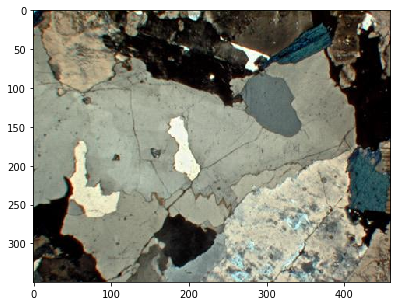

In [271]:
# this is just a test if the img is well readed
img = cv2.imread("geeks.jpg",1)
print_images(img)

# Pre-process evaluation

# First aproach 

Considering that I will start to use a well defined edge thin section with minerals like quartz and similar morphology, the previous process will focus on detecting larger grains rather than inclusions or similar.

To achieve that goal the first I must define which color channel I must work.

---

from the 4th paper I found that :

> *we discuss how various color models are use in finding the saliency map. The RGB color map is use for color feature extraction. The HSV (hue, saturation, value) discus the brightness of the color image. And the YCbCr means grey level luminance and chrominance which is use for shade distribution.*

given this information I consider to began the process with the following chanels :

- RGB 
- HSV
- HSL
- YCBCR

so I proceed to change channels and see the behavior in histogram and images

---



In [272]:
def img_color_channel_change(img):
  # RGB
  img_red,img_green,img_blue = cv2.split(img)
  # Gray
  img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
  # HSV hue-saturation-value
  img_hsv = cv2.cvtColor(img,cv2.COLOR_BGR2HSV)
  img_h,img_s,img_v = cv2.split(img_hsv)
  # HSL hue-saturation-lightness
  img_hsL = cv2.cvtColor(img,cv2.COLOR_BGR2HLS)
  img_h2,img_s2,img_v2 = cv2.split(img_hsv)
  # YCBCR
  img_YBR = cv2.cvtColor(img,cv2.COLOR_BGR2YCR_CB)
  img_Y,img_B2,img_R2 = cv2.split(img_YBR)

  return img_hsv,img_hsL,img_YBR,img_gray

def plot_hist(img):
  plt.figure(figsize=(20,4))
  color = ('b','g','r')

  for i,col in enumerate(color):
      histr = cv2.calcHist([img],[i],None,[256],[0,256])
      plt.plot(histr,color = col,drawstyle='steps-pre')
      plt.xlim([0,256])
  plt.grid(1)
  plt.show()

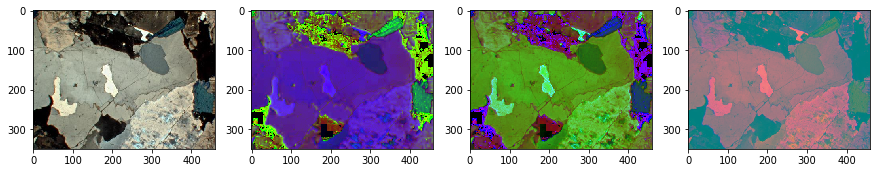

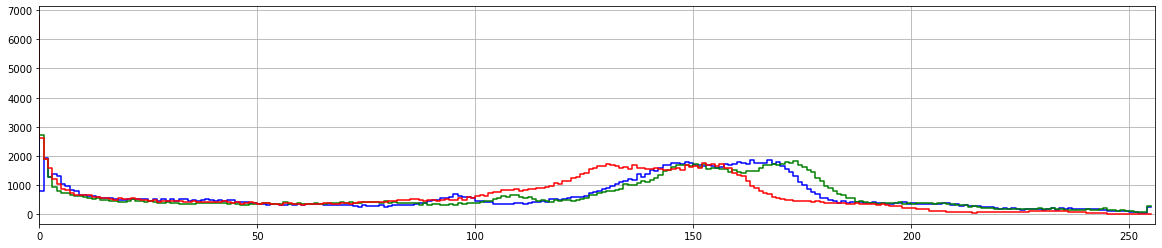

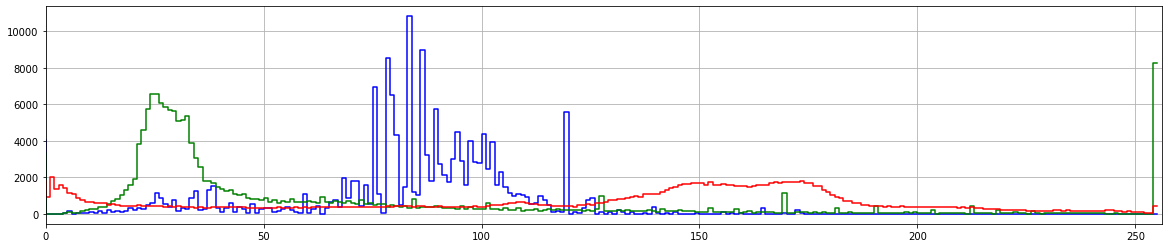

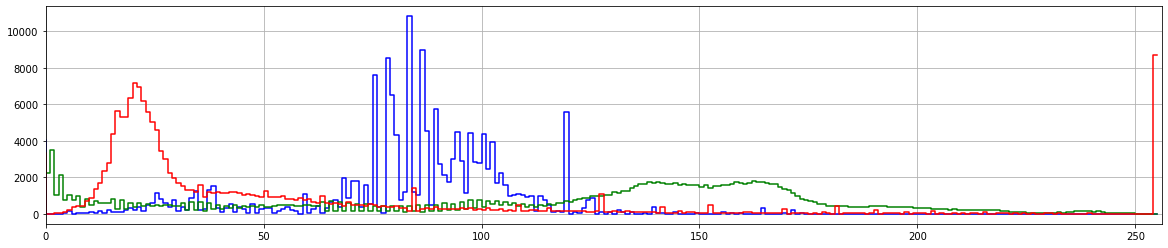

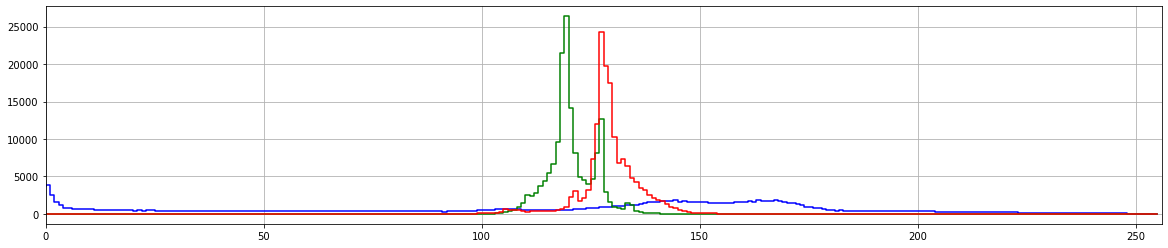

In [273]:
img_hsv,img_hsL,img_YBR,img_gray = img_color_channel_change(img)
print_images(img,img_hsv,img_hsL,img_YBR)
plot_hist(img)
plot_hist(img_hsv)
plot_hist(img_hsL)
plot_hist(img_YBR)

# Discussion Color change 

First thing I saw on the change of color channel is that  for edge detection is importan to reduce the noise coming from inclusions, it can be found specially in the HSL and HSV chanel where some cristals has well defined edges but inside has a lot minerals, that could be a problem in others thin sections.


I also need a dataset of images to compare and generate a real analysis about the histograms, i have the intuition that some channels will create  modimodal distributions



# Second aproach 

make some goblal operation , with this aproach I want to explore the following global operation : 


*  Hough Transformation
*  Hadamard Transformation 
*  Karhunen Transfomation 

with this transformation I focusing in future work with the use of convolutuional network to generate a first clasification 
 

# Proccess 

# blurring 

once is define wich is the best color channel to work and if there is necessary a global transformation to improve the convolution process to detected edges now is time to reduce mineral noises, this can reduce inclusions in minerals and some features of interest, but as we said we want to detect macro minerals and then mask to classified the mineral , is necessary to made some blur in the image

To make this bluring procces consider two process :
 - gassian blur
 - bilateral 
 - mean shift filterring 

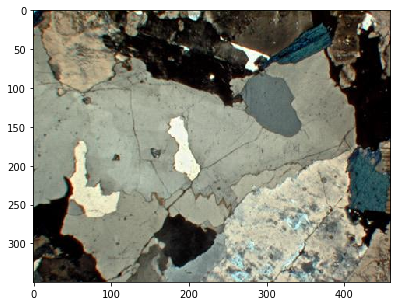

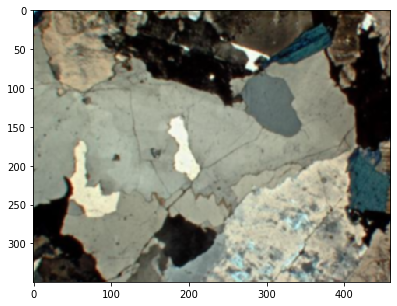

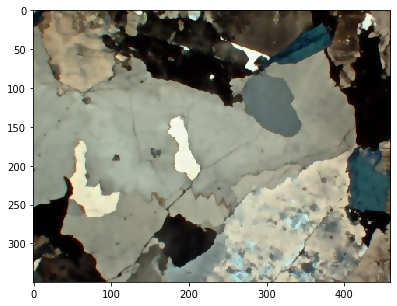

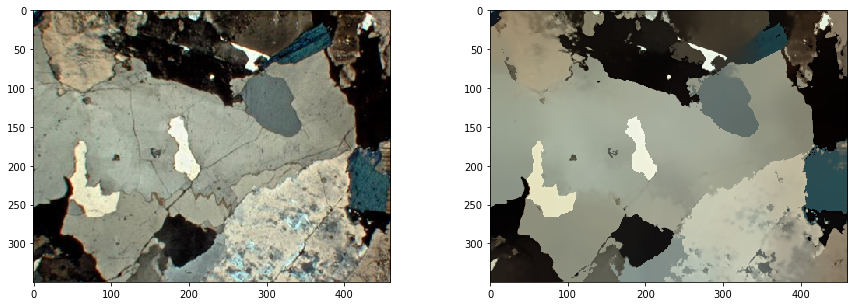

In [274]:
gausian = cv2.GaussianBlur(img,(5,5),0)
bilateral =cv2.bilateralFilter(img , 9, 75, 75, cv2.BORDER_DEFAULT);
meanshift = cv2.pyrMeanShiftFiltering(img,sp=21,sr=50)

print_images(img)
print_images(gausian)
print_images(bilateral)
print_images(img,meanshift)


In [275]:
# import time
# import cv2
# for color in range(5,100,10):
#   meanshift = cv2.pyrMeanShiftFiltering(img,sp=color,sr=50)
#   print_images(img,meanshift)


# Discution bluring proces 

All bluring process have pros and conts to reduce noise indeed to detect edges is imperative to select the right color channel and bluring process,because some thin section has more shape variety and others have more color divesity, therefore from this point I begin to consider the  need of a algorithm that can select the correct preproces for given sections 


#### Little conclution

*gausian blur is shit for this process*,since don't make a greath smoothing process, Also helps to lose information about the edges 

---



# Border detection 

- canny 
- prewit
- 




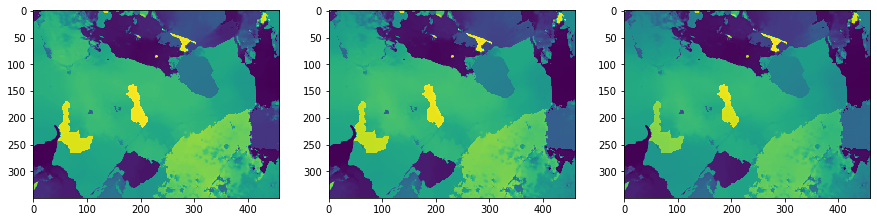

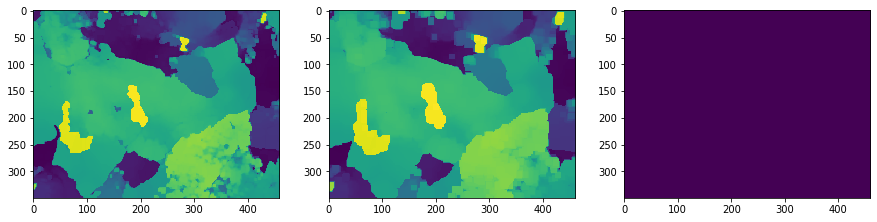

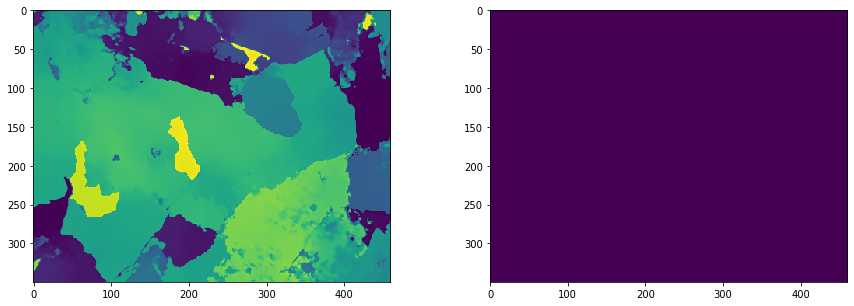

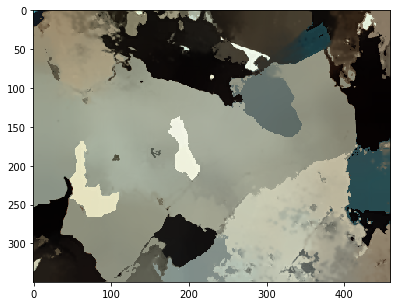

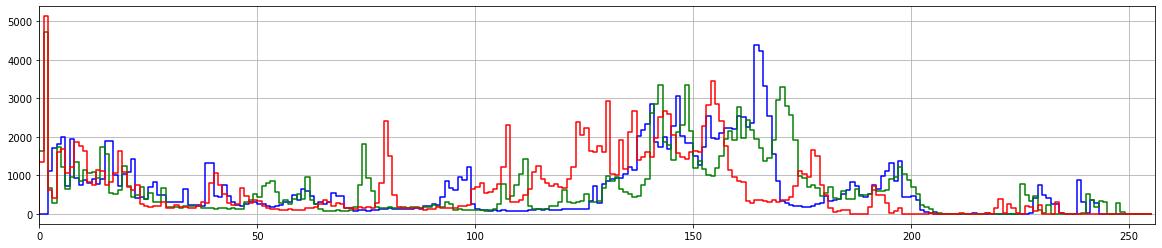

In [276]:
c1,c2,c3 = cv2.split(meanshift)
print_images(c1,c2,c3)

kernel = np.ones((3,3),np.uint8)
opening = cv2.morphologyEx(c1,cv2.MORPH_OPEN,kernel, iterations = 2)
sure_bg = cv2.dilate(opening,kernel,iterations=3)
dist_transform = cv2.distanceTransform(opening,cv2.DIST_L2,5)
ret, sure_fg = cv2.threshold(dist_transform,0.7*dist_transform.max(),255,0)
print_images(opening,sure_bg,dist_transform)

sure_fg = np.uint8(sure_fg)
unknown = cv2.subtract(sure_bg,sure_fg)

print_images(c2,sure_fg)

print_images(meanshift)
plot_hist(meanshift)

# morpho change


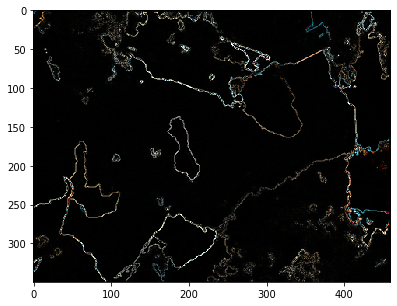

In [277]:
gray_scr =   cv2.cvtColor( meanshift , cv2.COLOR_BGR2GRAY )
laplacian = cv2.Laplacian(meanshift,ddepth = cv2.CV_64FC3, ksize=1 )
laplacian = cv2.convertScaleAbs(laplacian)
print_images(laplacian)

# countours 

---


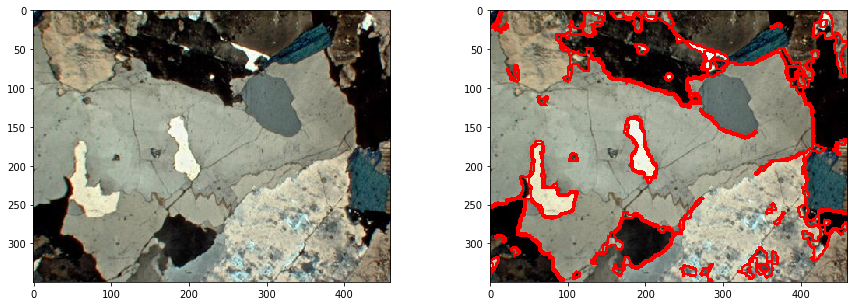

In [291]:
kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (5,5))


img_hsv,img_hsL,img_YBR,img_gray = img_color_channel_change(img)
# print_images(img,img_hsv,img_hsL,img_YBR)

meanshift = cv2.pyrMeanShiftFiltering(img,sp=5,sr=70)
gray_scr = cv2.cvtColor( meanshift , cv2.COLOR_BGR2GRAY )

# print_images(img,meanshift,gray_scr)

laplacian = cv2.Laplacian(meanshift,ddepth = cv2.CV_32FC3, ksize=3 )
laplacian = cv2.convertScaleAbs(laplacian)

closing = cv2.cv2.morphologyEx(laplacian,cv2.MORPH_CLOSE, kernel)

ret, binary = cv2.threshold(closing,50,180,cv2.THRESH_BINARY)
# print_images(laplacian,closing, binary )

original = img.copy()
binary =   cv2.cvtColor( binary , cv2.COLOR_BGR2GRAY )
cnts = cv2.findContours(binary, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
cnts = cnts[0] if len(cnts) == 2 else cnts[1]

for c in cnts:
  area = cv2.contourArea(c)
  if area > 50:
    cv2.drawContours(original,[c], 0, (250,0,0), 2)
  
print_images(img, original)
  

In [279]:

# contours, hierarchy = cv2.findContours(binary,cv2.RETR_TREE,cv2.CHAIN_APPROX_SIMPLE)


# print_images(canny_cracks ,laplacian,binary)

# print(len(contours))
# v = img.copy()
# v2 = img.copy()

# v = cv2.drawContours(v, contours, -1, (150,0,0), 3)
# v2 = cv2.drawContours(v2, contours2, -1, (150,0,0), 3)

# print_images(img,v,v2)

287


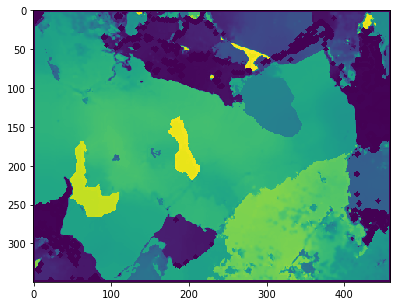

In [280]:
contours, hierarchy = cv2.findContours(cv2.split(img)[0], cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
print(len(contours))
cv2.drawContours(c2, contours, -1, (0,255,0), 3)
print_images(c2)

# bibliografia

1. [Mineral grains recognition using computer vision and machine learning](https://www.sciencedirect.com/science/article/pii/S0098300419301037)
2. [dentification of Mineral Grains in a Petrographic Thin Section Using Phi- and Max-Images](https://link.springer.com/article/10.1023/B:MATG.0000041179.79093.87)
3. [Mineral Grain Boundary Detection With Image Processing Method: From Edge Detection Operation To Level Set Technique ](https://www.intechopen.com/books/image-segmentation/mineral-grain-boundary-detection-with-image-processing-method-from-edge-detection-operation-to-level)
4. [Comparative Study of RGB, HSV & YCbCr
Color Model Saliency Map](https://www.researchgate.net/publication/340084223_Comparative_Study_of_Parallelism_and_Pipelining_of_RGB_to_HSL_Colour_Space_Conversion_Architecture_on_FPGA)
5. [SciPy and OpenCV as an interactive computing environment for computer vision](https://www.researchgate.net/publication/276918706_SciPy_and_OpenCV_as_an_interactive_computing_environment_for_computer_vision?enrichId=rgreq-0a456e759b7f1cc1b62f4360c0d98eac-XXX&enrichSource=Y292ZXJQYWdlOzI3NjkxODcwNjtBUzoyMzA4NzUwOTA2NDkwODhAMTQzMjA1NjMxOTUyOQ%3D%3D&el=1_x_3&_esc=publicationCoverPdf)

##### Copyright 2020 

Author : [Johan Ramirez](https://www.github.com/joaramirezra)


In [281]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

---

Notes

- clasification can be done using countour convexity 
- number of colors 
- conected countours 
- size of countour 
- scarlar projection of s vector , can be used to see how much two products looks its each other in color chanel for the first intance 
or maybe use scalar projection

---

Furuture references

- [edges](https://pinetools.com/image-edge-detection)

- [TensorFlow Quantum](https://blog.tensorflow.org/2020/11/my-experience-with-tensorflow-quantum.html)
- [1](https://www.analyticsvidhya.com/blog/2019/04/introduction-image-segmentation-techniques-python/)